# Monte Carlo Simulation

## Initial Code setup

In [16]:
import numpy as np
import pandas as pd

POLICY_CURRENT = 'current'
POLICY_PROPOSED = 'proposed'
POLICY_INVALID = 'Invalid Policy'
REPLACEMENTS_VALUE = 45
SEED_VALUE = 42

# consistent colors for all charts
COLORS_DICT = {
    "Fans": "steelblue",
    "Labor": "darkorange",
    "Downtime": "green"
}
COLORS_SIM_DICT = ["royalblue", "firebrick"]  # distinct policy colors

# Fan life distribution, refers to 'Table1_FanLife' sheet
fan_life_values = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900] #in hours
fan_life_probabilities  = [0.10, 0.13, 0.25, 0.13, 0.09, 0.12, 0.02, 0.06, 0.05, 0.05]

# Technician arrival distribution, refers to 'Table2_TechArrival' sheet
technician_arrival_times = [20, 30, 45] #in minutes
technician_arrival_time_probabilities  = [0.60, 0.30, 0.10]

# Costs, refers to 'Table3_costs' sheet
fan_cost = 32
server_downtime_cost_per_min = 10
labor_cost_per_hr = 30

# Replacement times (minutes), refers to 'Replacement_Time' sheet
# format is { 'number of fans replace' : 'time in minutes'}
replacement_times = {1: 20, 2: 30, 3: 40}


## Sampling functions

In [17]:
def sample_fan_life():
    return np.random.choice(fan_life_values, p=fan_life_probabilities)

def sample_tech_arrival():
    return np.random.choice(technician_arrival_times, p=technician_arrival_time_probabilities)

## Simulation function

In [18]:
def simulate_policy_detailed(policy=POLICY_CURRENT, total_replacements=REPLACEMENTS_VALUE, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Start with 3 installed fans
    active_fan_lifetimes = [sample_fan_life() for _ in range(3)]
    
    rows = []
    fans_replaced = 0
    cummulative_downtime = 0
    cummulative_cost = 0
    elapsed_time_hours = 0

    cummulative_fan_cost = 0
    cummulative_labor_cost = 0
    cummulative_downtime_cost = 0

    while fans_replaced < total_replacements:
        # Find the next failure time (minimum remaining life)
        failure_time = min(active_fan_lifetimes)
        elapsed_time_hours += failure_time

        # Remove the failed fan
        active_fan_lifetimes.remove(failure_time)

        # Policy: decide how many to replace and handle surviving fans
        if policy == POLICY_CURRENT:
            num_replaced = 1
            # Keep the other 2 fans; reduce their remaining life
            active_fan_lifetimes = [t - failure_time for t in active_fan_lifetimes]
        elif policy == POLICY_PROPOSED:
            num_replaced = 3
            # Replace ALL 3 fans — discard the two surviving ones
            active_fan_lifetimes = []  # clear remaining fans
        else:
            raise ValueError(POLICY_INVALID)

        # Don't exceed total_replacements
        num_replaced = min(num_replaced, total_replacements - fans_replaced)
        fans_replaced += num_replaced

        # Replacement time based on number replaced
        maint_time = replacement_times.get(num_replaced, 40)  # 1→20, 2→30, 3→40
        tech_delay = sample_tech_arrival()  # technician arrival delay (minutes)
        downtime_min = tech_delay + maint_time
        downtime_hr = downtime_min / 60.0

        # Costs
        fan_cost_total = num_replaced * fan_cost
        downtime_cost = downtime_min * server_downtime_cost_per_min
        labor_cost_total = (maint_time / 60) * labor_cost_per_hr
        total_cost = fan_cost_total + downtime_cost + labor_cost_total

        # Update cumulative values
        cummulative_downtime += downtime_hr
        cummulative_cost += total_cost
        cummulative_fan_cost += fan_cost_total
        cummulative_labor_cost += labor_cost_total
        cummulative_downtime_cost += downtime_cost

        # Add new fans with fresh, full lifetimes
        for _ in range(num_replaced):
            active_fan_lifetimes.append(sample_fan_life())

        # Record the event
        rows.append({
            "Fan Fail Life (hrs)": round(failure_time, 2),
            "Fans Replaced": num_replaced,
            "Total Fans Replaced": fans_replaced,
            "Random Tech Arrival (min)": tech_delay,
            "Maintenance Time (min)": maint_time,
            "Down time (hrs)": round(downtime_hr, 2),
            "Cummulative downtime": round(cummulative_downtime, 2),
            "Fan Cost": fan_cost_total,
            "Total Fans Cost": cummulative_fan_cost,
            "Labor Cost": round(labor_cost_total, 2),
            "Total Labor Cost": round(cummulative_labor_cost, 2),
            "Server Downtime Cost": downtime_cost,
            "Total Downtime Cost": cummulative_downtime_cost,
            "Total Cost": round(total_cost, 2),
            "Cummulative Total Cost": round(cummulative_cost, 2),
            "Time (hr * 100)": round(elapsed_time_hours * 100, 0)
        })

    # Return DataFrame with correct column order
    col_order = [
        "Fan Fail Life (hrs)", "Fans Replaced", "Total Fans Replaced",
        "Random Tech Arrival (min)", "Maintenance Time (min)",
        "Down time (hrs)", "Cummulative downtime",
        "Fan Cost", "Total Fans Cost",
        "Labor Cost", "Total Labor Cost",
        "Server Downtime Cost", "Total Downtime Cost",
        "Total Cost", "Cummulative Total Cost", "Time (hr * 100)"
    ]
    return pd.DataFrame(rows)[col_order]

## *Simulation v1* - Simulation run with *Current Policy*
<p>Preview first 10 rows like Excel Simulation V1</p>

In [19]:
#df_current = simulate_policy_detailed(POLICY_CURRENT, total_replacements=REPLACEMENTS_VALUE, seed=SEED_VALUE)
df_current = simulate_policy_detailed(POLICY_CURRENT, total_replacements=REPLACEMENTS_VALUE)
df_current.head(10) 

,Fan Fail Life (hrs),Fans Replaced,Total Fans Replaced,Random Tech Arrival (min),Maintenance Time (min),Down time (hrs),Cummulative downtime,Fan Cost,Total Fans Cost,Labor Cost,Total Labor Cost,Server Downtime Cost,Total Downtime Cost,Total Cost,Cummulative Total Cost,Time (hr * 100)
0,1100,1,1,20,20,0.67,0.67,32,32,10.0,10.0,400,400,442.0,442.0,110000
1,0,1,2,30,20,0.83,1.50,32,64,10.0,20.0,500,900,542.0,984.0,110000
2,400,1,3,20,20,0.67,2.17,32,96,10.0,30.0,400,1300,442.0,1426.0,150000
3,600,1,4,30,20,0.83,3.00,32,128,10.0,40.0,500,1800,542.0,1968.0,210000
4,500,1,5,20,20,0.67,3.67,32,160,10.0,50.0,400,2200,442.0,2410.0,260000
5,200,1,6,20,20,0.67,4.33,32,192,10.0,60.0,400,2600,442.0,2852.0,280000
6,900,1,7,45,20,1.08,5.42,32,224,10.0,70.0,650,3250,692.0,3544.0,370000
7,200,1,8,20,20,0.67,6.08,32,256,10.0,80.0,400,3650,442.0,3986.0,390000
8,400,1,9,20,20,0.67,6.75,32,288,10.0,90.0,400,4050,442.0,4428.0,430000
9,800,1,10,30,20,0.83,7.58,32,320,10.0,100.0,500,4550,542.0,4970.0,510000


## *Simulation v2* -Simulation run with *Proposed Policy*
<p>Preview first 10 rows like Excel Simulation V2</p>

In [20]:
#df_proposed = simulate_policy_detailed(POLICY_PROPOSED, total_replacements=REPLACEMENTS_VALUE, seed=SEED_VALUE)
df_proposed = simulate_policy_detailed(POLICY_PROPOSED, total_replacements=REPLACEMENTS_VALUE)
df_proposed.head(10) 

,Fan Fail Life (hrs),Fans Replaced,Total Fans Replaced,Random Tech Arrival (min),Maintenance Time (min),Down time (hrs),Cummulative downtime,Fan Cost,Total Fans Cost,Labor Cost,Total Labor Cost,Server Downtime Cost,Total Downtime Cost,Total Cost,Cummulative Total Cost,Time (hr * 100)
0,1200,3,3,45,40,1.42,1.42,96,96,20.0,20.0,850,850,966.0,966.0,120000
1,1200,3,6,20,40,1.00,2.42,96,192,20.0,40.0,600,1450,716.0,1682.0,240000
2,1000,3,9,20,40,1.00,3.42,96,288,20.0,60.0,600,2050,716.0,2398.0,340000
3,1300,3,12,20,40,1.00,4.42,96,384,20.0,80.0,600,2650,716.0,3114.0,470000
4,1000,3,15,20,40,1.00,5.42,96,480,20.0,100.0,600,3250,716.0,3830.0,570000
5,1200,3,18,20,40,1.00,6.42,96,576,20.0,120.0,600,3850,716.0,4546.0,690000
6,1200,3,21,20,40,1.00,7.42,96,672,20.0,140.0,600,4450,716.0,5262.0,810000
7,1300,3,24,30,40,1.17,8.58,96,768,20.0,160.0,700,5150,816.0,6078.0,940000
8,1500,3,27,20,40,1.00,9.58,96,864,20.0,180.0,600,5750,716.0,6794.0,1090000
9,1300,3,30,30,40,1.17,10.75,96,960,20.0,200.0,700,6450,816.0,7610.0,1220000


## Simulation Results Comparison

In [21]:
def build_results(df_sim_v1, df_sim_v2, formatted=True):
    # Convert hr*100 back to hours
    hours_passed_v1 = df_sim_v1["Time (hr * 100)"].iloc[-1] / 100
    hours_passed_v2 = df_sim_v2["Time (hr * 100)"].iloc[-1] / 100

    days_equiv_v1 = hours_passed_v1 / 24
    days_equiv_v2 = hours_passed_v2 / 24

    results = pd.DataFrame({
        "Simulation": ["Simulation V1", "Simulation V2"],
        "Total Cost": [
            df_sim_v1["Cummulative Total Cost"].iloc[-1],
            df_sim_v2["Cummulative Total Cost"].iloc[-1]
        ],
        "Total Fans Cost": [
            df_sim_v1["Total Fans Cost"].iloc[-1],
            df_sim_v2["Total Fans Cost"].iloc[-1]
        ],
        "Total Labor Cost": [
            df_sim_v1["Total Labor Cost"].iloc[-1],
            df_sim_v2["Total Labor Cost"].iloc[-1]
        ],
        "Total Downtime Cost": [
            df_sim_v1["Total Downtime Cost"].iloc[-1],
            df_sim_v2["Total Downtime Cost"].iloc[-1]
        ],
        "Hours Passed": [hours_passed_v1, hours_passed_v2],
        "Days Equivalent": [days_equiv_v1, days_equiv_v2],
        "Cost / Time": [
            df_sim_v1["Cummulative Total Cost"].iloc[-1] / hours_passed_v1,
            df_sim_v2["Cummulative Total Cost"].iloc[-1] / hours_passed_v2
        ]
    })

    if formatted:
        results_fmt = results.copy()
        results_fmt["Total Cost"] = results_fmt["Total Cost"].map("${:,.2f}".format)
        results_fmt["Total Fans Cost"] = results_fmt["Total Fans Cost"].map("${:,.2f}".format)
        results_fmt["Total Labor Cost"] = results_fmt["Total Labor Cost"].map("${:,.2f}".format)
        results_fmt["Total Downtime Cost"] = results_fmt["Total Downtime Cost"].map("${:,.2f}".format)
        results_fmt["Hours Passed"] = results_fmt["Hours Passed"].map("{:,.2f}".format)
        results_fmt["Days Equivalent"] = results_fmt["Days Equivalent"].map("{:,.2f}".format)
        results_fmt["Cost / Time"] = results_fmt["Cost / Time"].map("${:,.2f}".format)
        return results, results_fmt
    
    return results


results_numeric, results_summary = build_results(df_current, df_proposed, formatted=True)


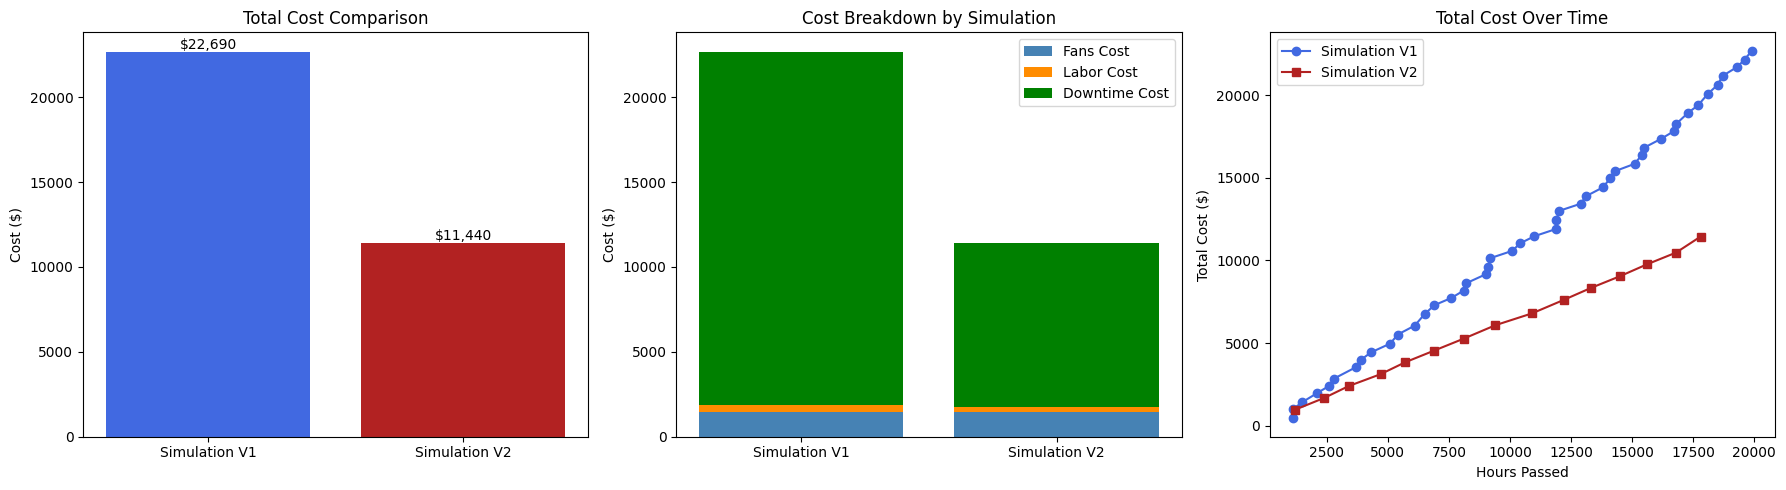

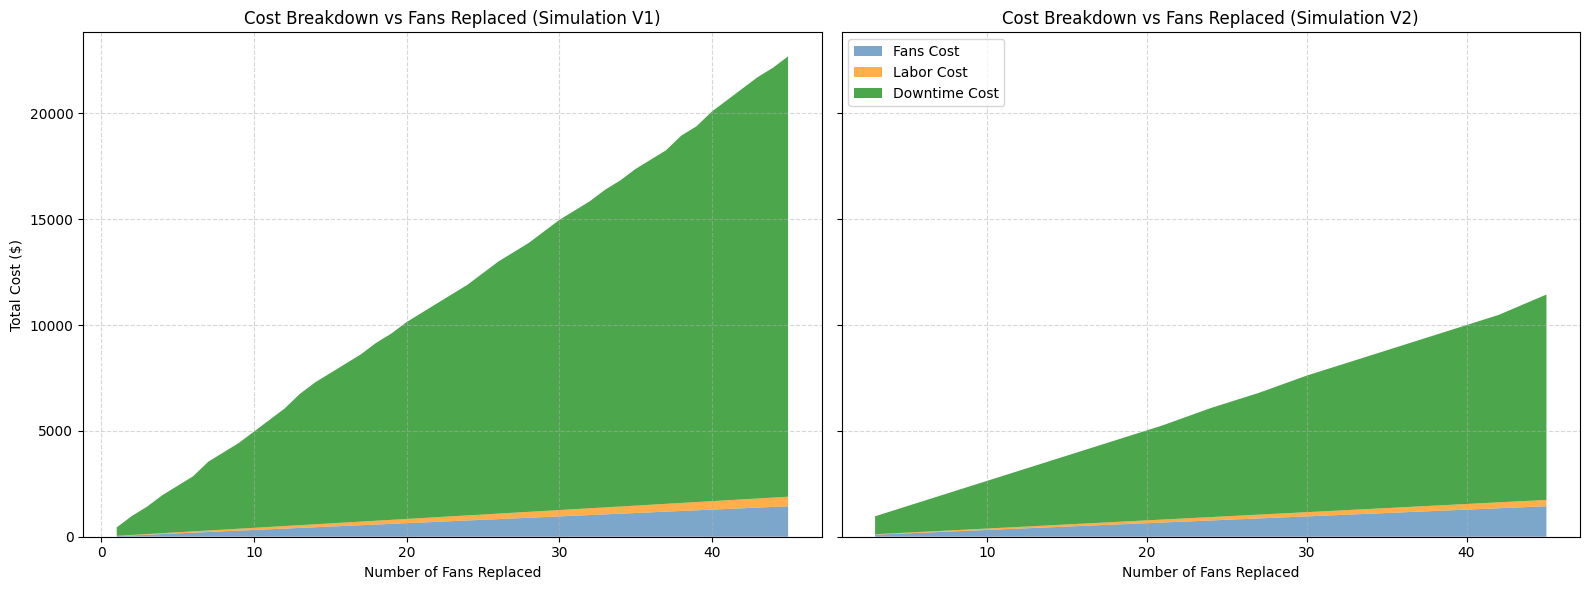

,Simulation,Total Cost,Total Fans Cost,Total Labor Cost,Total Downtime Cost,Hours Passed,Days Equivalent,Cost / Time
0,Simulation V1,"$22,690.00","$1,440.00",$450.00,"$20,800.00","19,900.00",829.17,$1.14
1,Simulation V2,"$11,440.00","$1,440.00",$300.00,"$9,700.00","17,800.00",741.67,$0.64


In [22]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

# ============================
# RESULTS DASHBOARD (1x3)
# ============================
fig, axes = plt.subplots(1, 3, figsize=(18,5))
p = np.arange(len(results_numeric["Simulation"]))

# --- 1. Total Cost Comparison ---
bars = axes[0].bar(results_numeric["Simulation"], results_numeric["Total Cost"], 
                   color=COLORS_SIM_DICT)
axes[0].set_title("Total Cost Comparison")
axes[0].set_ylabel("Cost ($)")
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, f"${height:,.0f}", 
                 ha="center", va="bottom")

# --- 2. Cost Breakdown by Simulation (Stacked Bar) ---
bars1 = axes[1].bar(p, results_numeric["Total Fans Cost"], label="Fans Cost", color=COLORS_DICT["Fans"])
bars2 = axes[1].bar(p, results_numeric["Total Labor Cost"], 
                    bottom=results_numeric["Total Fans Cost"], label="Labor Cost", color=COLORS_DICT["Labor"])
bars3 = axes[1].bar(p, results_numeric["Total Downtime Cost"], 
                    bottom=results_numeric["Total Fans Cost"]+results_numeric["Total Labor Cost"], 
                    label="Downtime Cost", color=COLORS_DICT["Downtime"])
axes[1].set_xticks(p)
axes[1].set_xticklabels(results_numeric["Simulation"])
axes[1].set_title("Cost Breakdown by Simulation")
axes[1].set_ylabel("Cost ($)")
axes[1].legend()

# --- 3. Cummulative Total Cost over Time (Line Chart) ---
axes[2].plot(df_current["Time (hr * 100)"]/100, df_current["Cummulative Total Cost"], 
             label="Simulation V1", color=COLORS_SIM_DICT[0], marker="o")
axes[2].plot(df_proposed["Time (hr * 100)"]/100, df_proposed["Cummulative Total Cost"], 
             label="Simulation V2", color=COLORS_SIM_DICT[1], marker="s")
axes[2].set_title("Total Cost Over Time")
axes[2].set_xlabel("Hours Passed")
axes[2].set_ylabel("Total Cost ($)")
axes[2].legend()

plt.tight_layout()
plt.show()

# ================================
# 2. COST BREAKDOWN STACKPLOTS
# ================================
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# --- Left: Simulation V1 ---
axes[0].stackplot(
    df_current["Total Fans Replaced"], 
    df_current["Total Fans Cost"], 
    df_current["Total Labor Cost"], 
    df_current["Total Downtime Cost"],
    labels=["Fans Cost", "Labor Cost", "Downtime Cost"],
    colors=[COLORS_DICT["Fans"], COLORS_DICT["Labor"], COLORS_DICT["Downtime"]],
    alpha=0.7
)
axes[0].set_title("Cost Breakdown vs Fans Replaced (Simulation V1)")
axes[0].set_xlabel("Number of Fans Replaced")
axes[0].set_ylabel("Total Cost ($)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Right: Simulation V2 ---
axes[1].stackplot(
    df_proposed["Total Fans Replaced"], 
    df_proposed["Total Fans Cost"], 
    df_proposed["Total Labor Cost"], 
    df_proposed["Total Downtime Cost"],
    labels=["Fans Cost", "Labor Cost", "Downtime Cost"],
    colors=[COLORS_DICT["Fans"], COLORS_DICT["Labor"], COLORS_DICT["Downtime"]],
    alpha=0.7
)
axes[1].set_title("Cost Breakdown vs Fans Replaced (Simulation V2)")
axes[1].set_xlabel("Number of Fans Replaced")
axes[1].grid(True, linestyle="--", alpha=0.5)

# Legend once
axes[1].legend(loc="upper left")




plt.tight_layout()
plt.show()
results_summary
